## Linear-Controlled Quadratic-Cost Optimal Control Problems

# Colab Specifics

In [70]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    %cd /content/drive/MyDrive/ml-adp/
    !git pull
    import sys
    sys.path.insert(0, '/content/drive/MyDrive/ml-adp/src/')
except:
    pass

# Imports

In [71]:
import torch
from torch import nn
from ml_adp import cost as cst
from ml_adp import finance, nn
from ml_adp.mapping import linear, convex
import importlib
importlib.reload(finance)
importlib.reload(cst)
importlib.reload(linear)
importlib.reload(convex)
importlib.reload(finance)
from torch.distributions import uniform, categorical, normal
import itertools as it
import functools as ft
import matplotlib.pyplot as plt
import copy

# Device Settings

In [72]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


# Linear-Controlled-Quadratic-Cost Stochastic Test Case

# Problem Specification

In [73]:
#torch.einsum(
#    'b...k,bjk->b...j',
#    torch.rand(50,4,5,6,3),
#    torch.rand(50,7,3)
#).size()
# 
# torch.einsum(
#    'bm...n,bn->bm...',
#    torch.rand(50,3,3,4),
#    torch.rand(50,4,5)
#).size()
# torch.rand(50,4,4)[1,2]


In [74]:
horizon = 1
steps = 20
step_size = horizon/steps

state_space_size = 1
rand_eff_space_size = state_space_size
control_space_size = 1

B = torch.eye(state_space_size)
C = torch.ones((state_space_size, control_space_size))
D = torch.eye(state_space_size).unsqueeze(2)
Q = torch.eye(state_space_size)
P = torch.eye(state_space_size)
lam = 1.0
R = lam * torch.eye(control_space_size)

linear_quadratic = cst.CostToGo.from_steps(steps)
linear_quadratic.state_functions[:-1] = linear.LinearControlledStep(B, C, D, step_size)
for step in range(len(linear_quadratic) - 1):
    linear_quadratic.cost_functions[step]= linear.QuadraticStepCost.from_sym_tensorrep(Q, R, step_size)
linear_quadratic.cost_functions[-1] = linear.QuadraticStepCost.from_sym_tensorrep(P, 0.*R, 1.0)


for step in range(len(linear_quadratic)):
    #linear_quadratic[step, 'control_func'] = linear.LinearMap(torch.zeros(1, state_space_size, control_space_size))
    
    linear_quadratic.control_functions[step] = linear.FFN.from_config([state_space_size, 120 + state_space_size, 100 + state_space_size, control_space_size])

linear_quadratic._register_modules()

state_samplers = []
stand_normal = normal.Normal(torch.tensor(0.).to(device), torch.tensor(1.0).to(device))
for step in range(len(linear_quadratic)):
    state_samplers.append(lambda sim_size: stand_normal.sample([sim_size, state_space_size]))

normal_increment = lambda sim_size, steps: [stand_normal.sample([sim_size, rand_eff_space_size]) for step in range(steps)]


linquad_model = {
                'cost_to_go': linear_quadratic.to(device), 
                'rand_effs_sampler': normal_increment,
                'states_samplers': state_samplers
                }

/Users/rubenwiedemann/Library/Caches/pypoetry/virtualenvs/ml-adp-2N881lJP-py3.7/lib/python3.7/site-packages/torch/nn/init.py:388: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


# NNContPi

In [75]:
model = copy.deepcopy(linquad_model)
cost_to_go = model['cost_to_go']
rand_effs_sampler = model['rand_effs_sampler']
states_samplers = model['states_samplers']

In [76]:
sims_size = 10000
mc_iterations = 500

cost_to_go.eval()

print("Optimizing the following model using NNContiPi-Algorithm:")
print(cost_to_go)

for step in range(len(cost_to_go) - 1, -1, -1):
    
    states_sampler = states_samplers[step]

    rel_cost_to_go = cost_to_go[step:]
    rel_cost_to_go.control_functions[0].train()

    optimizer = torch.optim.Adam(rel_cost_to_go.control_functions[0].parameters(), lr=1e-6)
    #scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

    print("Minizimg the first control of")
    print(rel_cost_to_go.__repr__(optimizer=optimizer, include_id=True))

    for iteration in range(mc_iterations):

        rand_effs = rand_effs_sampler(sims_size, len(rel_cost_to_go))
        states = states_sampler(sims_size)

        cost = rel_cost_to_go(states, rand_effs).mean()

        if iteration % 50 == 0:
            print(f"Step {step}, MC Iteration {iteration}: Cost {cost}")
            #scheduler.step()
            #print(rel_cost_to_go[0, 'control_func'].linear_rep)


        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

    if state_space_size == 1:
        rel_cost_to_go.plot_state_component_range(
            torch.arange(-3, 3.25, 0.25).to(device),
            random_effects=rand_effs,
            plot_size=(12,8)   
        )
    plt.show()

    rel_cost_to_go.eval()

Optimizing the following model using NNContiPi-Algorithm:
CostToGo(
step |       state_func       |      control_func      |       cost_func        
    0           None                  FFN(eval)          QuadraticS...st(eval)  
    1  LinearCont...ep(eval)          FFN(eval)          QuadraticS...st(eval)  
    2  LinearCont...ep(eval)          FFN(eval)          QuadraticS...st(eval)  
    3  LinearCont...ep(eval)          FFN(eval)          QuadraticS...st(eval)  
    4  LinearCont...ep(eval)          FFN(eval)          QuadraticS...st(eval)  
    5  LinearCont...ep(eval)          FFN(eval)          QuadraticS...st(eval)  
    6  LinearCont...ep(eval)          FFN(eval)          QuadraticS...st(eval)  
    7  LinearCont...ep(eval)          FFN(eval)          QuadraticS...st(eval)  
    8  LinearCont...ep(eval)          FFN(eval)          QuadraticS...st(eval)  
    9  LinearCont...ep(eval)          FFN(eval)          QuadraticS...st(eval)  
   10  LinearCont...ep(eval)          FFN

[E thread_pool.cpp:112] Exception in thread pool task: mutex lock failed: Invalid argument


KeyboardInterrupt: 

In [ ]:
with torch.no_grad(), cst._evaluating(cost_to_go):
    print(rel_cost_to_go(torch.ones(state_space_size).to(device), rand_effs).mean())


tensor(1.2661)


In [ ]:
states = torch.arange(-3, 3.25, .25).unsqueeze(1).to(device)
control = cost_to_go.control_functions[-1]
with torch.no_grad(), cst._evaluating(control):
    controls = control(states)

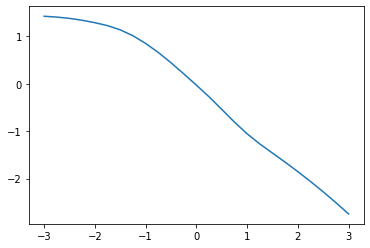

In [ ]:
plt.plot(states.cpu().squeeze().numpy(), controls.cpu().squeeze().numpy())

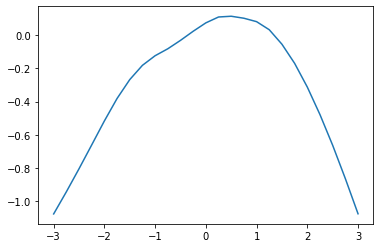

In [ ]:
plt.plot(states.cpu().squeeze().numpy(), controls.cpu().squeeze().numpy())

# Hybrid Now

# Set-Up

In [ ]:
model = copy.deepcopy(linquad_model)
model['cost_approximators'] = []


class QuadVal(nn.Module):
    def __init__(self, config_net, config_params):
        super(QuadVal, self).__init__()

        self.picnn = convex.PICNN1( 
                            config_net, 
                            config_params, 
                            output_activation=None, 
                            param_hidden_activation=nn.ELU(),
                            floor_func=nn.Softplus()
                            )

    def forward(self, states, controls, random_effects):
        return self.picnn(states, torch.tensor([[1.]]).expand(states.size(0), -1))


input_config, param_config = [1] + [150] * 2 + [1], [1] + [50] * 2 +  [1]

# Loop

In [ ]:
sims_size = 10000

cost_to_go = model['cost_to_go']
rand_effs_sampler = model['rand_effs_sampler']
states_samplers = model['states_samplers']
cost_approximators = model['cost_approximators']


cost_approximator = cost_to_go[-1]  # This one is exact

for step in range(cost_to_go.steps()-1, -1, -1):

    states_sampler = states_samplers[step]

    rel_cost_to_go = cost_to_go[step] + cost_approximator
    rel_cost_to_go[0, 'state_func'] = None
    rel_cost_to_go[1, 'state_func'] = cost_to_go[step+1, 'state_func']

    rel_cost_to_go[0, 'control_func'].train()
    optimizer = torch.optim.Adam(rel_cost_to_go[0, 'control_func'].parameters(), lr=1e-6)

    print("Optimizing the following costtogo:")
    print(rel_cost_to_go.__repr__(optimizer=optimizer, include_id=True))

    for epoch in range(20):

        rand_effs = rand_effs_sampler(sims_size, len(rel_cost_to_go))
        states = states_sampler(sims_size)
        cost = rel_cost_to_go(states, None, rand_effs).mean()

        if epoch % 100 == 0:
            print(f"Step {step} Control Optimization: MC Iteration {epoch : >4}, Cost {cost : >18.5f}")

        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

    cost_approximator = cst.CostToGo.from_steps(0)
    cost_approximator[-1, 'cost_func'] = QuadVal(input_config, param_config)
    cost_approximator.to(device)
    cost_approximators.append(cost_approximator)

    cost_approximator.eval()
    cost_approximator[0, 'cost_func'].train()

    optimizer = torch.optim.Adam(cost_approximator[0, 'cost_func'].parameters(), lr=1e-3)

    print("Minimzing L2 distance between:")
    print(cost_approximator.__repr__(optimizer=optimizer, include_id=True))
    print(rel_cost_to_go.__repr__(optimizer=optimizer, include_id=True))

    for epoch in range(5000):

        rand_effs = rand_effs_sampler(sims_size, len(rel_cost_to_go))
        states = states_sampler(sims_size)

        approx_error = torch.norm(rel_cost_to_go(states, None, rand_effs) - cost_approximator(states, None, rand_effs), p=2)

        if epoch % 100 == 0:
            print(f"Step {step} Value Approximation: MC Iteration {epoch : >4}, Approximation Error {approx_error : >18.5f}")

        if epoch % 1000 == 0 and epoch > 0 & state_space_size == 1:
            cost_approximator.plot_state_component_range(
                torch.arange(-3., 3.25, 0.25),
                controls=None,
                random_effects=rand_effs,
                versus=rel_cost_to_go,
                plot_size=(8,5)
            )
            plt.show()

        approx_error.backward()
        optimizer.step()
        optimizer.zero_grad()

    cost_approximator.eval()

Optimizing the following costtogo:
CostToGo(
step |       state_func       |      control_func      |       cost_func        
    0            None           X  FFN(train;..1536)     - Q...st(train;..3776) 
    1  - L...ep(train;..2224)   -  FFN(train;..1360)     - Q...st(train;..8880) 
)
Step 19 Control Optimization: MC Iteration    0, Cost            1.13103
Minimzing L2 distance between:
CostToGo(
step |       state_func       |      control_func      |       cost_func        
    0            None                     None           X Q...al(train;..4336) 
)
CostToGo(
step |       state_func       |      control_func      |       cost_func        
    0            None           -  FFN(train;..1536)     - Q...st(train;..3776) 
    1  - L...ep(train;..2224)   -  FFN(train;..1360)     - Q...st(train;..8880) 
)
Step 19 Value Approximation: MC Iteration    0, Approximation Error        13650.98926
Step 19 Value Approximation: MC Iteration   10, Approximation Error        13251.47461
Ste

KeyboardInterrupt: 